In [1]:
!pip install vmdpy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import seaborn as sns
from vmdpy import VMD  # VMD library

In [4]:
# Load the dataset
df = pd.read_csv("cleaned_data1.csv")

# Convert 'Date/Time' to datetime format
df['Date/Time'] = pd.to_datetime(df['Date/Time'], errors='coerce')

# Extract time-based features
df['hour'] = df['Date/Time'].dt.hour
df['day'] = df['Date/Time'].dt.day
df['month'] = df['Date/Time'].dt.month
df['weekday'] = df['Date/Time'].dt.weekday

# Basic features
features = ['Wind Speed (m/s)', 'Wind Direction (°)', 'hour', 'day', 'month', 'weekday', 'Theoretical_Power_Curve (KWh)']
target = 'LV ActivePower (kW)'

# Drop missing values
df.dropna(subset=features + [target], inplace=True)

In [5]:
# Apply VMD to Wind Speed
def apply_vmd(signal, K=3, alpha=2000):
    tau = 0.         # Noise-tolerance (no strict fidelity)
    DC = 0           # Do not force DC mode
    init = 1         # Initialize omegas uniformly
    tol = 1e-7       # Convergence tolerance

    u, _, _ = VMD(signal, alpha, tau, K, DC, init, tol)
    return u

# Apply VMD and extract first 3 modes as features
wind_speed_signal = df['Wind Speed (m/s)'].values
vmd_modes = apply_vmd(wind_speed_signal, K=3)

# Add VMD modes to the DataFrame
for i in range(3):
    df[f'VMD_Mode_{i+1}'] = vmd_modes[i]

# Extended feature list
vmd_features = features + ['VMD_Mode_1', 'VMD_Mode_2', 'VMD_Mode_3']

# Split features and target
X = df[vmd_features]
y = df[target]

# Add Gaussian noise
def add_gaussian_noise(data, mean=0.0, std=0.01):
    noisy_data = data.copy()
    for col in ['Wind Speed (m/s)', 'Wind Direction (°)', 'Theoretical_Power_Curve (KWh)']:
        noise = np.random.normal(mean, std, size=noisy_data[col].shape)
        noisy_data[col] += noise
    return noisy_data

X_noisy = add_gaussian_noise(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_noisy, y, test_size=0.3, random_state=42)

# XGBoost Model
model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=9, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [6]:
# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

MSE : 0.0022
RMSE: 0.0468
MAE : 0.0186
R²  : 0.9833


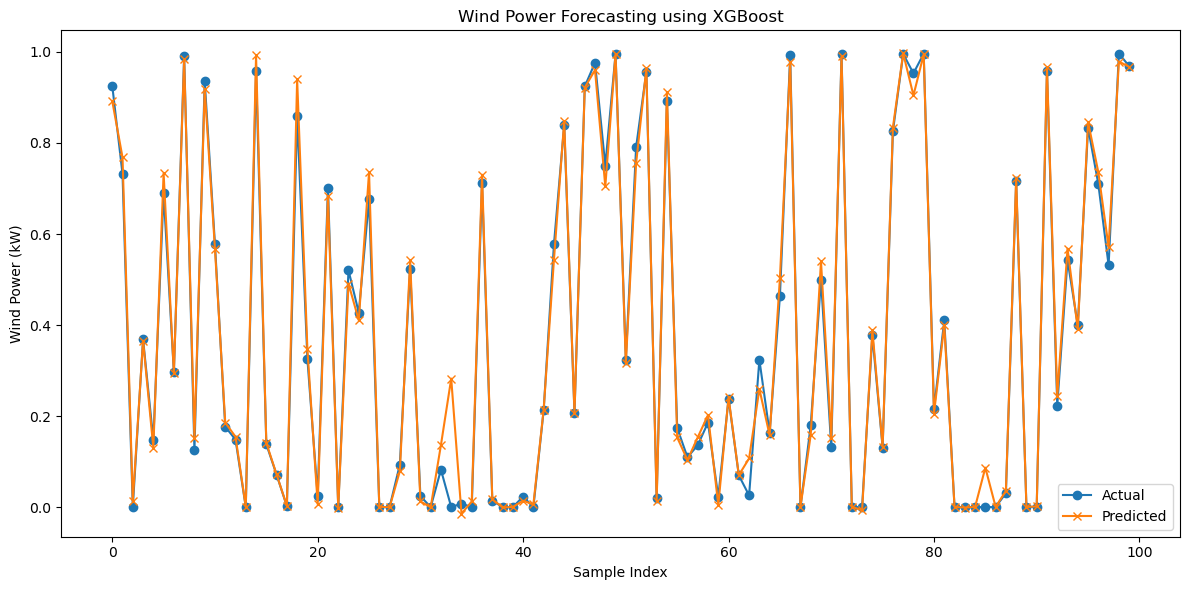

In [9]:
# Plot Actual vs Predicted (line plot)
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title('Wind Power Forecasting using XGBoost')
plt.xlabel('Sample Index')
plt.ylabel('Wind Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()